# Load library

In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
# DT
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# NB
from sklearn.naive_bayes import GaussianNB
# MLP
from sklearn.neural_network import MLPClassifier
# kNN
from sklearn.neighbors import KNeighborsClassifier
# Adafair
from AdaFair import AdaFair 
# Agarwal
from exponentiated_gradient_reduction import ExponentiatedGradientReduction
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
# DIR
from disparate_impact_remover import DisparateImpactRemover
# LFR
from learning_fair_representations import LFR
# EOP
from eq_odds_postprocessing import EqOddsPostprocessing
# CEP
from calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[LawSchoolGPA]'
2023-03-28 18:36:43.633632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 18:36:43.633657: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset

## Application

In [2]:
def load_application(): 
  df=pd.read_csv('data/application_train.csv')   #length: 307511
  df=df.dropna() #length: 8602
  df=df.drop(columns=['SK_ID_CURR'])

  protected_attribute = 'CODE_GENDER'
  majority_group_name = "M"
  minority_group_name = "F"
  class_label = 'TARGET'
    
  
  print("Length:",len(df))
  print("Number of attribute:",len(df.columns))

  le = preprocessing.LabelEncoder()
  for i in df.columns:
    if df[i].dtypes == 'object':
      df[i] = le.fit_transform(df[i])

  #Splitting data into train and test
  length = len(df.columns)
  X = df.iloc[:,1:length-1]
  y = df[class_label]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
  #Get index    
  feature = X.keys().tolist()    
  sa_index = feature.index(protected_attribute)
  print(sa_index)
  p_Group = 0 
    
  return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute,majority_group_name,minority_group_name

# Run experiment

In [3]:
def run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):    
    datasetTrain = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
    datasetTest = BinaryLabelDataset(df=pd.concat([X_test, y_test.to_frame()], axis=1), label_names=[y_test.name], protected_attribute_names=[protected_attribute])
    
    # preprocessing
    if preprocessing_algorithm != '': 
        if preprocessing_algorithm == 'DIR':
            pre_model = DisparateImpactRemover(sensitive_attribute=protected_attribute)
        elif preprocessing_algorithm == 'LFR':
            privileged_groups = [{protected_attribute: 1.0}]
            unprivileged_groups = [{protected_attribute: 0.0}]
            pre_model = LFR(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        dataset_train_transf = pre_model.fit_transform(datasetTrain)
        dataset_test_transf = pre_model.transform(datasetTest)

        X_train_transf = dataset_train_transf.features
        y_train_transf = dataset_train_transf.labels.ravel()
        X_test_transf = dataset_test_transf.features
        y_test_transf= dataset_test_transf.labels.ravel()

        X_train_transf = pd.DataFrame(X_train_transf, columns = X_train.columns)
        y_train_transf = pd.Series(y_train_transf, name = y_train.name).astype(int)
        X_test_transf = pd.DataFrame(X_test_transf, columns = X_train.columns)
        y_test_transf = pd.Series(y_test_transf, name = y_train.name).astype(int)
    
    # inprocessing
    if algorithm == 'DT':
        model = tree.DecisionTreeClassifier(random_state=0)  
    elif algorithm == 'NB': 
        model = GaussianNB()
    elif algorithm == 'MLP':
        model = MLPClassifier(random_state=1, max_iter=300)
    elif algorithm == 'kNN':
        model = KNeighborsClassifier(n_neighbors=5)
    elif algorithm == 'Ada':
        model = AdaFair(n_estimators=50, saIndex=sa_index, saValue=p_Group, CSB="CSB2", c=1, use_validation=False)
    elif algorithm == 'Agar':
        clf =  NB = GaussianNB()
        model = ExponentiatedGradientReduction(prot_attr=protected_attribute,estimator=clf, constraints = "EqualizedOdds")
    
    if preprocessing_algorithm != '':
        model.fit(X_train_transf, y_train_transf)
        y_predicts = model.predict(X_test_transf)
    else:
        model.fit(X_train,y_train)
        y_predicts = model.predict(X_test)

    # postprocessing
    if postprocessing_algorithm != '':
        privileged_groups = [{protected_attribute: 1.0}]
        unprivileged_groups = [{protected_attribute: 0.0}]
        if postprocessing_algorithm == 'EOP':
            post_model = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        if postprocessing_algorithm == 'CEP':
            post_model = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        
        y_test_predicts = model.predict(X_test)
        y_train_predicts = model.predict(X_train)

        X_train_predicts = X_train.copy()
        X_test_predicts = X_test.copy()

        X_train_predicts[y_train.name] = y_train_predicts
        X_test_predicts[y_train.name] = y_test_predicts
    
        dataset_train_true = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_train_predicts = BinaryLabelDataset(df=X_train_predicts, label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_test_predicts = BinaryLabelDataset(df=X_test_predicts, label_names=[y_test.name], protected_attribute_names=[protected_attribute])

        post_model.fit_predict(dataset_true=dataset_train_true, dataset_pred=dataset_train_predicts)
        dataset_predicts_transf = post_model.predict(dataset_test_predicts)
        data_predicts = dataset_predicts_transf.convert_to_dataframe()[0]
        y_predicts = data_predicts[y_test.name].astype(int)

    print("Statistical parity:")
    print(calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Equal opportunity")
    print(calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Equalized odds")
    print(calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Predictive parity")
    print(calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Predictive equality")
    print(calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Treatment equality")
    print(calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    filename = '{}.{}.abroca.pdf'.format(dataset, preprocessing_algorithm+algorithm)
    #make predictions
    if postprocessing_algorithm == '':
        if preprocessing_algorithm:
            X_test['pred_proba'] = model.predict_proba(X_test_transf)[:,1:2]
        else:
            X_test['pred_proba'] = model.predict_proba(X_test)[:,1:2]
        X_test['true_label'] = y_test
        df_test = X_test

        #Compute Abroca
        slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                            majority_protected_attr_val = 1, n_grid = 10000,
                            plot_slices = True, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
        print("ABROCA:",slice)
        plt.clf() 
    plt.clf() 

In [4]:
#Main function
def run_eval(dataset, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):
    if dataset == 'credit-approval':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_approval()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'credit-card':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_card()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'german-credit':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_german_credit()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                            
    if dataset == 'PAKDD':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_PAKDD2010()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                
    if dataset == 'credit-scoring':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_scoring()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                        
    if dataset == 'application':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_application()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                       

## application

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.0272737101976826}
Equal opportunity
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.013753106876553428, 'TPR_protected': 0.15492957746478872, 'TPR_non_protected': 0.1411764705882353, 'TNR_protected': 0.9414225941422594, 'TNR_non_protected': 0.9121951219512195}
Equalized odds
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.042980579067593255, 'TPR_protected': 0.15492957746478872, 'TPR_non_protected': 0.1411764705882353, 'TNR_protected': 0.9414225941422594, 'TNR_non_protected': 0.9121951219512195}
Predictive parity
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.035802469135802456, 'TPR_protected': 

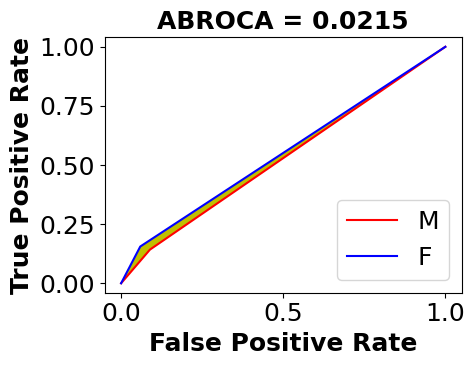

ABROCA: 0.021490287764710236


<Figure size 640x480 with 0 Axes>

In [5]:
run_eval(dataset='application', algorithm='DT')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

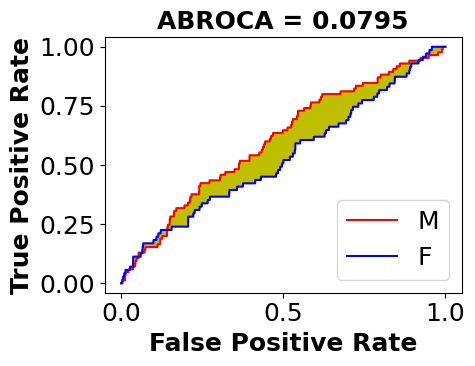

ABROCA: 0.0794583256065053


<Figure size 640x480 with 0 Axes>

In [6]:
run_eval(dataset='application', algorithm='NB')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

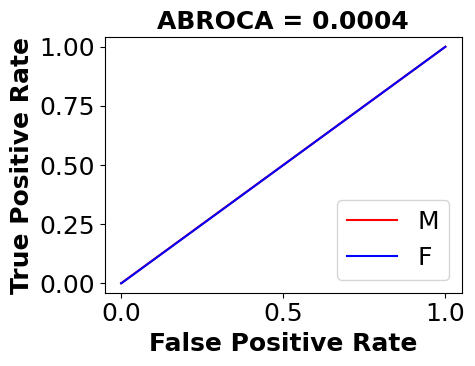

ABROCA: 0.0004187604690117745


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='application', algorithm='MLP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': -0.0016975113978339616}
Equal opportunity
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': 0.011764705882352941, 'TPR_protected': 0.0, 'TPR_non_protected': 0.011764705882352941, 'TNR_protected': 0.994979079497908, 'TNR_non_protected': 0.9975609756097561}
Equalized odds
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': 0.014346601994201055, 'TPR_protected': 0.0, 'TPR_non_protected': 0.011764705882352941, 'TNR_protected': 0.994979079497908, 'TNR_non_protected': 0.9975609756097561}
Predictive parity
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': 0.25, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0117647058

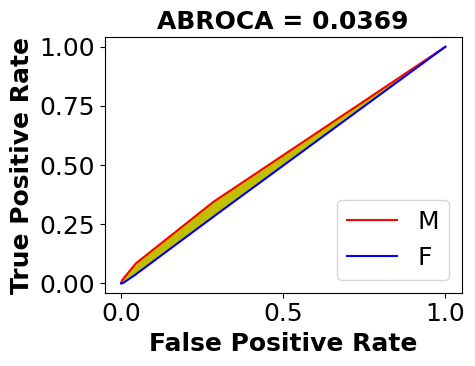

ABROCA: 0.036894310922102276


<Figure size 640x480 with 0 Axes>

In [8]:
run_eval(dataset='application', algorithm='kNN')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

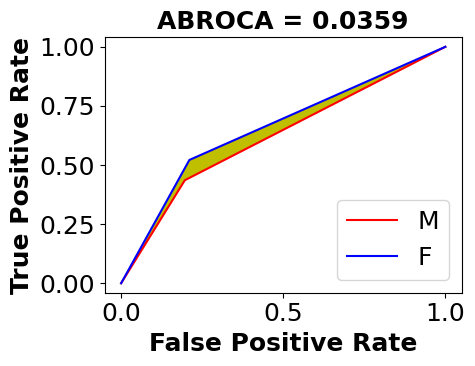

ABROCA: 0.03586287995656742


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval(dataset='application', algorithm='Ada')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

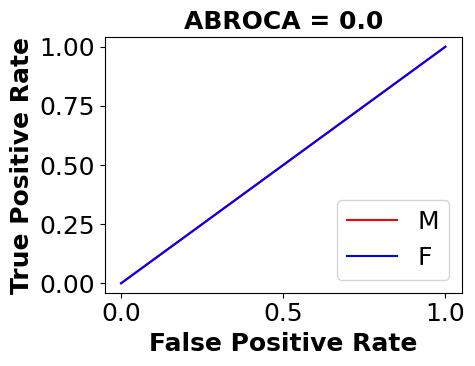

ABROCA: 0.0


<Figure size 640x480 with 0 Axes>

In [10]:
run_eval(dataset='application', algorithm='Agar')

In [11]:
run_eval(dataset='application', algorithm='DT', preprocessing_algorithm='DIR')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5654321966693101, 'accuracy': 0.8934521503293297, 'f1-score': 0.1791044776119403, 'fairness': 0.008993326485622816}
Equal opportunity
{'balanced_accuracy': 0.5654321966693101, 'accuracy': 0.8934521503293297, 'f1-score': 0.1791044776119403, 'fairness': 0.01690140845070423, 'TPR_protected': 0.18309859154929578, 'TPR_non_protected': 0.2, 'TNR_protected': 0.9422594142259414, 'TNR_non_protected': 0.9349593495934959}
Equalized odds
{'balanced_accuracy': 0.5654321966693101, 'accuracy': 0.8934521503293297, 'f1-score': 0.1791044776119403, 'fairness': 0.02420147308314971, 'TPR_protected': 0.18309859154929578, 'TPR_non_protected': 0.2, 'TNR_protected': 0.9422594142259414, 'TNR_non_protected': 0.9349593495934959}
Predictive parity
{'balanced_accuracy': 0.5654321966693101, 'accuracy': 0.8934521503293297, 'f1-score': 0.1791044776119403, 'fairness': 0.016721146592909214, 'TPR_protected': 0.18309859154929578, 'TPR_non_

In [12]:
run_eval(dataset='application', algorithm='NB', preprocessing_algorithm='DIR')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

In [13]:
run_eval(dataset='application', algorithm='MLP', preprocessing_algorithm='DIR')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': -0.003188990803644904}
Equal opportunity
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 0.99581589958159, 'TNR_non_protected': 0.9991869918699187}
Equalized odds
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': 0.0033710922883286587, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 0.99581589958159, 'TNR_non_protected': 0.9991869918699187}
Predictive parity
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 0.99581589958159, 'TNR_non_protected': 0.9991869918699187}
Predictive equality
{'balanced_accuracy': 0.4

In [14]:
run_eval(dataset='application', algorithm='kNN', preprocessing_algorithm='DIR')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': -8.829942515272207e-05}
Equal opportunity
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9974895397489539, 'TNR_non_protected': 0.9975609756097561}
Equalized odds
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': 7.143586080216036e-05, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9974895397489539, 'TNR_non_protected': 0.9975609756097561}
Predictive parity
{'balanced_accuracy': 0.49876288659793816, 'accuracy': 0.9372336303758233, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 0.9974895397489539, 'TNR_non_protected': 0.9975609756097561}
Predictive equality
{'balanced_accurac

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5186558287073751, 'accuracy': 0.34908950019372337, 'f1-score': 0.1167192429022082, 'fairness': 0.02236558364718666}
Equal opportunity
{'balanced_accuracy': 0.5186558287073751, 'accuracy': 0.34908950019372337, 'f1-score': 0.1167192429022082, 'fairness': 0.09096934548467273, 'TPR_protected': 0.6619718309859155, 'TPR_non_protected': 0.7529411764705882, 'TNR_protected': 0.33472803347280333, 'TNR_non_protected': 0.3170731707317073}
Equalized odds
{'balanced_accuracy': 0.5186558287073751, 'accuracy': 0.34908950019372337, 'f1-score': 0.1167192429022082, 'fairness': 0.10862420822576874, 'TPR_protected': 0.6619718309859155, 'TPR_non_protected': 0.7529411764705882, 'TNR_protected': 0.33472803347280333, 'TNR_non_protected': 0.3170731707317073}
Predictive parity
{'balanced_accuracy': 0.5186558287073751, 'accuracy': 0.34908950019372337, 'f1-score': 0.1167192429022082, 'fairness': 0.014976982742311816, 'TPR_protected

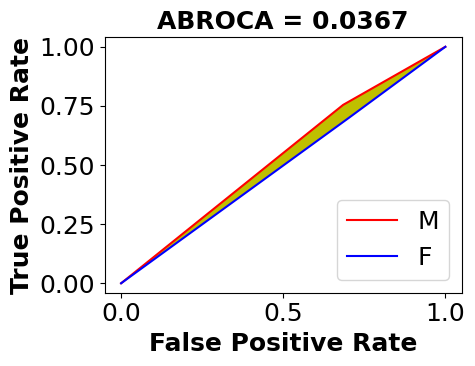

ABROCA: 0.03665724055131427


<Figure size 640x480 with 0 Axes>

In [5]:
run_eval(dataset='application', algorithm='DT', preprocessing_algorithm='LFR')

In [6]:
run_eval(dataset='application', algorithm='NB', preprocessing_algorithm='LFR')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

IndexError: index 0 is out of bounds for axis 0 with size 0

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.06044168926772569, 'f1-score': 0.11399342345633905, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.06044168926772569, 'f1-score': 0.11399342345633905, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.06044168926772569, 'f1-score': 0.11399342345633905, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.06044168926772569, 'f1-score': 0.11399342345633905, 'fairness': 0.008556634770751866, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.06044168926772569, 'f1-score': 0.11399342345633905, 'fairness': 0.0, 'TPR_protected

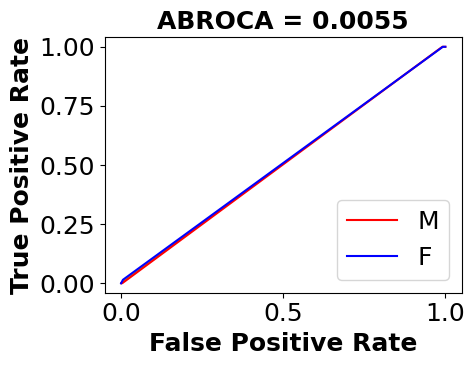

ABROCA: 0.005545392052194676


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='application', algorithm='MLP', preprocessing_algorithm='LFR')

In [8]:
run_eval(dataset='application', algorithm='kNN', preprocessing_algorithm='LFR')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
run_eval(dataset='application', algorithm='DT', postprocessing_algorithm='EOP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.0272737101976826}
Equal opportunity
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.013753106876553428, 'TPR_protected': 0.15492957746478872, 'TPR_non_protected': 0.1411764705882353, 'TNR_protected': 0.9414225941422594, 'TNR_non_protected': 0.9121951219512195}
Equalized odds
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.042980579067593255, 'TPR_protected': 0.15492957746478872, 'TPR_non_protected': 0.1411764705882353, 'TNR_protected': 0.9414225941422594, 'TNR_non_protected': 0.9121951219512195}
Predictive parity
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.035802469135802456, 'TPR_protected': 

In [ ]:
run_eval(dataset='application', algorithm='NB', postprocessing_algorithm='EOP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

In [ ]:
run_eval(dataset='application', algorithm='MLP', postprocessing_algorithm='EOP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

In [ ]:
run_eval(dataset='application', algorithm='kNN', postprocessing_algorithm='EOP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': -0.0016975113978339616}
Equal opportunity
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': 0.011764705882352941, 'TPR_protected': 0.0, 'TPR_non_protected': 0.011764705882352941, 'TNR_protected': 0.994979079497908, 'TNR_non_protected': 0.9975609756097561}
Equalized odds
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': 0.014346601994201055, 'TPR_protected': 0.0, 'TPR_non_protected': 0.011764705882352941, 'TNR_protected': 0.994979079497908, 'TNR_non_protected': 0.9975609756097561}
Predictive parity
{'balanced_accuracy': 0.5013494581020355, 'accuracy': 0.936458736923673, 'f1-score': 0.012048192771084336, 'fairness': 0.25, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0117647058

In [ ]:
run_eval(dataset='application', algorithm='DT', postprocessing_algorithm='CEP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.0272737101976826}
Equal opportunity
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.013753106876553428, 'TPR_protected': 0.15492957746478872, 'TPR_non_protected': 0.1411764705882353, 'TNR_protected': 0.9414225941422594, 'TNR_non_protected': 0.9121951219512195}
Equalized odds
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.042980579067593255, 'TPR_protected': 0.15492957746478872, 'TPR_non_protected': 0.1411764705882353, 'TNR_protected': 0.9414225941422594, 'TNR_non_protected': 0.9121951219512195}
Predictive parity
{'balanced_accuracy': 0.5370169177901136, 'accuracy': 0.8795040681906238, 'f1-score': 0.1288515406162465, 'fairness': 0.035802469135802456, 'TPR_protected': 

In [ ]:
run_eval(dataset='application', algorithm='NB', postprocessing_algorithm='CEP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

In [ ]:
run_eval(dataset='application', algorithm='MLP', postprocessing_algorithm='CEP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.9395583107322744, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Treatment equality
{

In [ ]:
run_eval(dataset='application', algorithm='kNN', postprocessing_algorithm='CEP')

Length: 8602
Number of attribute: 121
1
Statistical parity:
{'balanced_accuracy': 0.5015556436690457, 'accuracy': 0.9368461836497481, 'f1-score': 0.01212121212121212, 'fairness': -0.0009076219823521284}
Equal opportunity
{'balanced_accuracy': 0.5015556436690457, 'accuracy': 0.9368461836497481, 'f1-score': 0.01212121212121212, 'fairness': 0.011764705882352941, 'TPR_protected': 0.0, 'TPR_non_protected': 0.011764705882352941, 'TNR_protected': 0.99581589958159, 'TNR_non_protected': 0.9975609756097561}
Equalized odds
{'balanced_accuracy': 0.5015556436690457, 'accuracy': 0.9368461836497481, 'f1-score': 0.01212121212121212, 'fairness': 0.013509781910519034, 'TPR_protected': 0.0, 'TPR_non_protected': 0.011764705882352941, 'TNR_protected': 0.99581589958159, 'TNR_non_protected': 0.9975609756097561}
Predictive parity
{'balanced_accuracy': 0.5015556436690457, 'accuracy': 0.9368461836497481, 'f1-score': 0.01212121212121212, 'fairness': 0.25, 'TPR_protected': 0.0, 'TPR_non_protected': 0.011764705882